# Etapas (código fonte)

1. ETL
2. EDA
3. Linear_reg
4. Modelos Gaussianos

Este notebook se refere ao item 4, o qual se caracteriza como uma continuação do projeto do Porto realizado na disciplina de PI3.

Para mais detalhes do projeto anterior (itens 1, 2 e 3), basta conferir a publicação dos próprios autores: https://semanaacademica.org.br/artigo/porto-de-santos-analise-da-movimentacao-de-carga-e-perspectivas-futuras


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importação das bibliotecas necessárias para o projeto

In [2]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import pytensor.tensor as tt

# Importação da base de dados

In [3]:
# Carregamento dos dados a partir de um arquivo CSV localizado no Google Drive.
original = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PI5/staging/porto_ts.csv')

In [4]:
original

,ano,mes,porto,graos,outras,sugar
0,2005,1,5027941,412400,1780376,581383
1,2005,2,5316605,707274,1821686,878016
2,2005,3,5899912,1221079,1917759,610140
3,2005,4,5850639,1301598,1976311,764285
4,2005,5,6826372,1575474,2122232,1007705
...,...,...,...,...,...,...
211,2022,8,14626790,4122517,3188229,2455597
212,2022,9,13628567,3743920,3258989,2079487
213,2022,10,14435751,4185655,3198681,2249483
214,2022,11,12194409,3459541,2558110,2199680


### Alguns ajustes para o projeto atual

In [5]:
# remoção de colunas desnecessárias
original.drop(['graos','outras','sugar'], axis=1, inplace=True)

In [6]:
original

,ano,mes,porto
0,2005,1,5027941
1,2005,2,5316605
2,2005,3,5899912
3,2005,4,5850639
4,2005,5,6826372
...,...,...,...
211,2022,8,14626790
212,2022,9,13628567
213,2022,10,14435751
214,2022,11,12194409


In [7]:
# Conversão das colunas 'ano' e 'mes' para um índice datetime.
original['data'] = pd.to_datetime(original['ano'].astype(str) + '-' + original['mes'].astype(str), format='%Y-%m')
original['lastDay'] = original['data'] + pd.offsets.MonthBegin(0)   # set a data no início do mês
#original['lastDay'] = original['data'] + pd.offsets.MonthEnd(0)    # set a data no final do mês

original['data'] = original['lastDay'].dt.strftime("%Y-%m-%d")
original.drop(['lastDay'], axis=1, inplace=True)
original['data'] = pd.to_datetime(original['data'])
print(original)

      ano  mes     porto       data
0    2005    1   5027941 2005-01-01
1    2005    2   5316605 2005-02-01
2    2005    3   5899912 2005-03-01
3    2005    4   5850639 2005-04-01
4    2005    5   6826372 2005-05-01
..    ...  ...       ...        ...
211  2022    8  14626790 2022-08-01
212  2022    9  13628567 2022-09-01
213  2022   10  14435751 2022-10-01
214  2022   11  12194409 2022-11-01
215  2022   12  12096270 2022-12-01

[216 rows x 4 columns]


# Normalização dos dados

## Normalização da data


In [9]:
min_month = original.index.min()
max_month = original.index.max()
print(min_month, max_month)
data_std = (original.index - min_month)/(max_month-min_month)
original['data_std'] = data_std

0 215


## Normalização da movimentação

In [10]:
maximo_mov = original.porto.max()
minimo_mov = original.porto.min()
print(maximo_mov, minimo_mov)
mov_std = (original.porto - minimo_mov) / (maximo_mov - minimo_mov)
original['porto_std'] = mov_std
original

15165869 4588410


,ano,mes,porto,data,data_std,porto_std
0,2005,1,5027941,2005-01-01,0.000000,0.041554
1,2005,2,5316605,2005-02-01,0.004651,0.068844
2,2005,3,5899912,2005-03-01,0.009302,0.123990
3,2005,4,5850639,2005-04-01,0.013953,0.119332
4,2005,5,6826372,2005-05-01,0.018605,0.211578
...,...,...,...,...,...,...
211,2022,8,14626790,2022-08-01,0.981395,0.949035
212,2022,9,13628567,2022-09-01,0.986047,0.854662
213,2022,10,14435751,2022-10-01,0.990698,0.930974
214,2022,11,12194409,2022-11-01,0.995349,0.719076


## Gerando dataframe apenas com dados necessários

In [11]:
original_std = original[['data_std', 'porto_std', 'data']]
original_std.index = original_std.data_std
original_std.drop(['data_std'], axis=1,inplace=True)
original_std

<ipython-input-11-80cc1b98794f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original_std.drop(['data_std'], axis=1,inplace=True)


,porto_std,data
data_std,,
0.000000,0.041554,2005-01-01
0.004651,0.068844,2005-02-01
0.009302,0.123990,2005-03-01
0.013953,0.119332,2005-04-01
0.018605,0.211578,2005-05-01
...,...,...
0.981395,0.949035,2022-08-01
0.986047,0.854662,2022-09-01
0.990698,0.930974,2022-10-01


# Não normalizados

In [ ]:
#original = original[['data','porto']]
#original

# Divisão dos dados em Treino / Teste  aproximadamente 80%

In [13]:
# Definindo os dados para treinamento
d = original.data.values.T
# normalizado
x = original_std.index.values.T
y = original_std.porto_std.values.T

# percentual para treinamento
perc = 0.8                          # o mais próximo possível
periodo = int(len(x) * perc // 12)       # período em anos
n = periodo * 12
treino_split = n-1       # anos para treino /total
more_months = len(d) - n
# Exibindo a divisão de dados para treino
print(f'{n} meses\n{n/12} anos\n{treino_split/216*100:.2f} %')
print(more_months)

168 meses
14.0 anos
77.31 %
48


In [14]:
# Final do período de treino
original.iloc[treino_split]

ano                         2018
mes                           12
porto                   10863015
data         2018-12-01 00:00:00
data_std                0.776744
porto_std               0.593205
Name: 167, dtype: object

In [15]:
# separação treino/teste
x_treino = x[:treino_split+1]
x_teste  = x[treino_split+1: ]

d_treino = d[:treino_split+1]       # para plotagem
d_teste  = d[treino_split+1: ]

y_treino = y[:treino_split+1]
y_teste  = y[treino_split+1:]

In [16]:
print(len(x_treino), len(y_treino), len(x_teste), len(y_teste))

168 168 48 48


In [17]:
#x_treino
x_teste
#y_treino
#y_teste

array([0.78139535, 0.78604651, 0.79069767, 0.79534884, 0.8       ,
       0.80465116, 0.80930233, 0.81395349, 0.81860465, 0.82325581,
       0.82790698, 0.83255814, 0.8372093 , 0.84186047, 0.84651163,
       0.85116279, 0.85581395, 0.86046512, 0.86511628, 0.86976744,
       0.8744186 , 0.87906977, 0.88372093, 0.88837209, 0.89302326,
       0.89767442, 0.90232558, 0.90697674, 0.91162791, 0.91627907,
       0.92093023, 0.9255814 , 0.93023256, 0.93488372, 0.93953488,
       0.94418605, 0.94883721, 0.95348837, 0.95813953, 0.9627907 ,
       0.96744186, 0.97209302, 0.97674419, 0.98139535, 0.98604651,
       0.99069767, 0.99534884, 1.        ])

[Text(0.5, 1.0, 'Separação Treino / Teste'),
 Text(0.5, 0, 't'),
 Text(0, 0.5, '')]

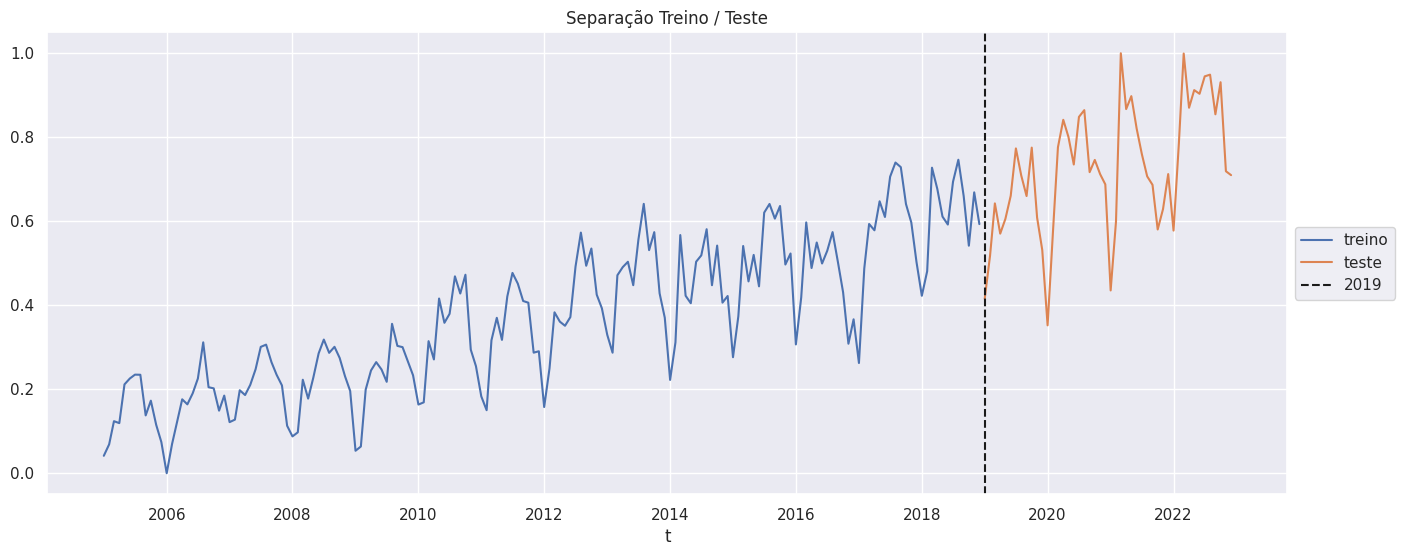

In [19]:
# Plotagem do gráfico da série temporal já dividida em treino/teste
fig, ax = plt.subplots(figsize=(16,6))
sns.set_theme(context='notebook', style='darkgrid', palette='deep',
                  font='sans-serif', font_scale=1, color_codes=True, rc=None)
sns.lineplot(x=d_treino, y=y_treino, label='treino', ax=ax)
sns.lineplot(x=d_teste, y=y_teste, label='teste', ax=ax)
ax.axvline(x=d_teste[0], linestyle='--', label=(2005+periodo), color='k')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set(title='Separação Treino / Teste', xlabel='t', ylabel='')


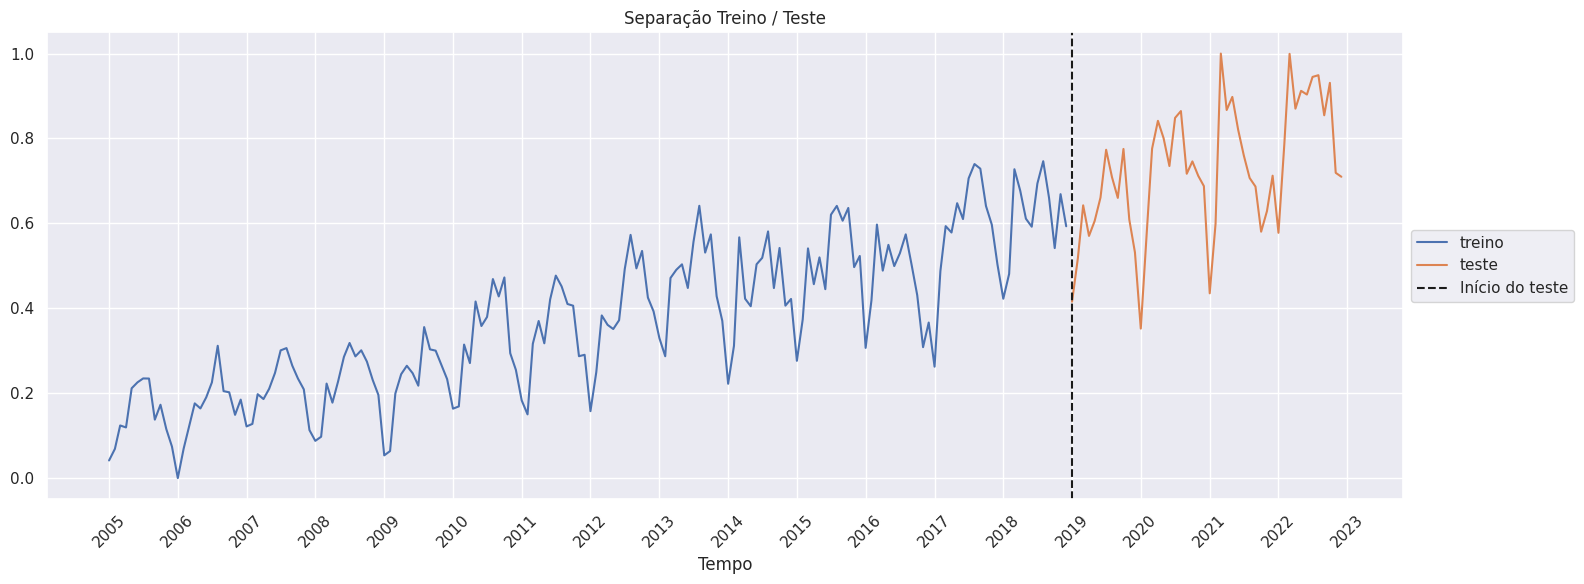

In [20]:
import matplotlib.dates as mdates

#Supondo que x_treino e x_teste sejam arrays de datas
fig, ax = plt.subplots(figsize=(16,6))

sns.lineplot(x=d_treino, y=y_treino, label='treino', ax=ax)
sns.lineplot(x=d_teste, y=y_teste, label='teste', ax=ax)

# Adicionando linha de separação entre treino e teste
ax.axvline(x=d_teste[0], linestyle='--', label='Início do teste', color='k')

# Configurando formatação do eixo x para datas mensais
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45)

# Configurando a legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Definindo títulos e rótulos
ax.set(title='Separação Treino / Teste', xlabel='Tempo', ylabel='')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

# O modelo Prophet (Meta)

**Definição:** O Prophet é uma ferramenta de modelagem de séries temporais que combina métodos de decomposição aditiva. O modelo Prophet separa a série temporal em três componentes principais:

**Tendência (Trend):** Representa a componente que modela as mudanças não periódicas e de longo prazo na série temporal.<br>
**Sazonalidade (Seasonality):** Modela os padrões periódicos que se repetem regularmente, como sazonalidade diária, semanal, mensal, ou anual.<br>
**Feriados e Eventos (Holidays and Events):** São componentes que modelam irregularidades que não seguem um padrão fixo, como feriados ou eventos especiais que podem ter efeitos sobre a série temporal.

A fórmula é dada por:

A fórmula usada pelo Prophet para modelar uma série temporal y(t) é expressa como:
$y(t)=g(t)+s(t)+h(t)+ ɛ$

onde:
- g(t) representa a função de tendência, que modela mudanças não periódicas na série temporal.
- s(t) representa a função de sazonalidade, capturando padrões periódicos dentro dos dados.
- h(t) representa os efeitos de feriados e eventos específicos.
- ɛ é o termo de erro, assumindo que os resíduos dos dados são normalmente distribuídos.

# Modelo Phophet - FFT

In [21]:
# Definição da Ordem de Fourier
n_order = 10       # para season ano 10  testar 12

# Função para gerar recursos de Fourier para modelar a sazonalidade
def get_fourier(n_points,periods):

  x_f = np.linspace(0, periods, n_points) # `n_points` é o número de pontos de dados e `periods` é o número de períodos

  fourier_features = pd.DataFrame(
    {
        f"{func}_order_{order}": getattr(np, func)(2 * np.pi * x_f / periods * order) # `x_f` cria uma sequência linear de pontos
        for order in range(1, n_order + 1)
        for func in ("sin", "cos")
    }
  )

  return fourier_features

In [22]:
# Definição de Coordenadas
coords = {"fourier_features": np.arange(2 * n_order)}
coords

{'fourier_features': array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19])}

In [52]:
# Definição do Modelo
with pm.Model(coords=coords) as prophet_p:
    X_ = pm.MutableData("X",x_treino)
    y_ = pm.MutableData("y",y_treino)
    n = X_.eval().shape[0]
    fs = get_fourier(n, 36.525)      # testar p/12: 30.4375   p/10 36.525
    fourier_f = pm.MutableData("f_f",fs.values)

    β_fourier = pm.Gamma("β_fourier", mu=5, sigma=5, dims="fourier_features")
    seasonality = pm.Deterministic(
        "seasonality", pm.math.dot(β_fourier, fourier_f.T)
    )
    # tendência linear
    a = 0.15
    b = 0.8
    trend = pm.Normal('trend', mu=a + b * X_, sigma=0.2)

    μ = trend * (1 + seasonality)

    σ = pm.HalfNormal("σ", sigma=1)
    pm.Normal("likelihood", mu=μ, sigma=σ, observed=y_)

In [53]:
# Amostragem Preditiva A Priori e Visualização
with prophet_p:
  p_prior_p = pm.sample_prior_predictive()

Este código está criando um gráfico com dois subgráficos (subplots) para visualizar a distribuição preditiva a priori e as linhas de tendência a priori do modelo, utilizando as bibliotecas Matplotlib e Seaborn.

<ipython-input-54-c9dd279c0ed4>:5: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior_predictive", num_samples=168)["likelihood"]
<ipython-input-54-c9dd279c0ed4>:14: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior", num_samples=168)["trend"] * y_treino.max(),
<ipython-input-54-c9dd279c0ed4>:22: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(p_prior_p, group="prior", num_samples=168)["seasonality"]


Text(0.5, 1.0, 'Prior seasonality')

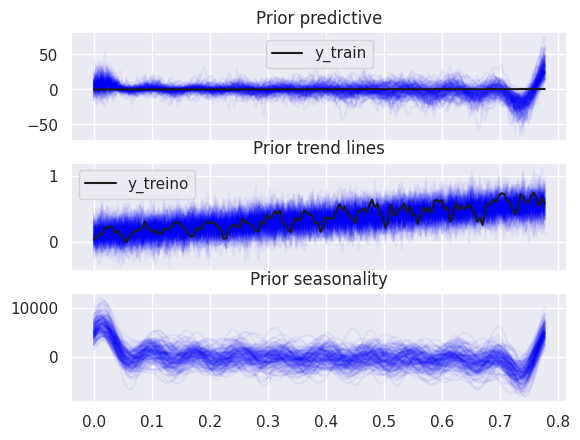

In [54]:
# Visualização dos Resultados: previsões a priori, as linhas de tendência e a sazonalidade
fig, ax = plt.subplots(nrows=3, ncols=1, sharex=True)
ax[0].plot(
    x_treino,
    az.extract_dataset(p_prior_p, group="prior_predictive", num_samples=168)["likelihood"]
    * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino, y=y_treino, color="k", label='y_train', ax=ax[0])
ax[0].set_title("Prior predictive")
ax[1].plot(
    x_treino,
    az.extract_dataset(p_prior_p, group="prior", num_samples=168)["trend"] * y_treino.max(),
    color="blue",
    alpha=0.05,
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k",label='y_treino', ax=ax[1])
ax[1].set_title("Prior trend lines")
ax[2].plot(
    x_treino,
    az.extract_dataset(p_prior_p, group="prior", num_samples=168)["seasonality"]
    * 100,
    color="blue",
    alpha=0.05,
)
ax[2].set_title("Prior seasonality")

In [55]:
# Ajuste do Modelo com Dados Observados
with prophet_p:
  trace_p_p = pm.sample()

In [56]:
# Amostragem Posterior Preditiva
with prophet_p:
  trace_post_p = pm.sample_posterior_predictive(trace_p_p)

<ipython-input-57-a678849ec105>:5: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],


Text(0.5, 1.0, 'Posterior predictive')

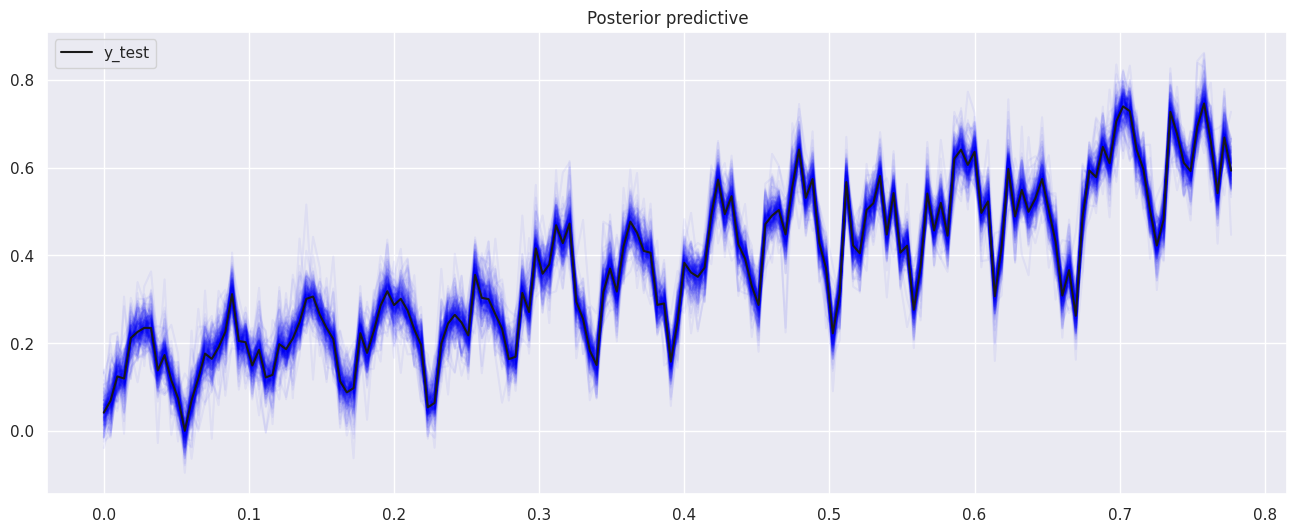

In [57]:
# Visualização das Previsões a Posteriori
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_treino,
    az.extract_dataset(trace_post_p, group="posterior_predictive", num_samples=200)["likelihood"],
    color="blue",
    alpha=0.05
)
sns.lineplot(x=x_treino.flatten(), y=y_treino.flatten(), color="k", label='y_test', ax=ax)
ax.set_title("Posterior predictive")

O bloco abaixo calcula e imprime o erro absoluto médio (MAE) das previsões a posteriori em relação aos dados de treinamento.

Para avaliar a acurácia das previsões (median_house_predictive) do nosso modelo em comparação com os dados de teste, calculamos uma métrica de erro comum: o Erro Médio Absoluto (MAE). Esse cálculo nos ajudam a compreender a magnitude dos erros nas previsões.

In [58]:
# Cálculo do MAE
y_pred = trace_post_p.posterior_predictive["likelihood"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_treino).sum()/len(y_treino)}")

MAE: 0.002480096660773075


In [59]:
y_pred

array([ 4.35550249e-02,  6.64684809e-02,  1.19214904e-01,  1.18969128e-01,
        2.15652648e-01,  2.23336156e-01,  2.36411391e-01,  2.32048553e-01,
        1.42705103e-01,  1.75459161e-01,  1.12710153e-01,  7.32857454e-02,
       -1.30454686e-04,  6.54240194e-02,  1.21458428e-01,  1.74544933e-01,
        1.64931508e-01,  1.93187528e-01,  2.30688521e-01,  3.12335138e-01,
        2.02662312e-01,  2.01859227e-01,  1.53301627e-01,  1.86655980e-01,
        1.19749324e-01,  1.27732939e-01,  2.02104502e-01,  1.84130027e-01,
        2.14219517e-01,  2.42394766e-01,  3.00682508e-01,  2.98308774e-01,
        2.65194819e-01,  2.36325988e-01,  2.12038980e-01,  1.16386518e-01,
        9.17165257e-02,  9.96387701e-02,  2.26025801e-01,  1.75254545e-01,
        2.25350073e-01,  2.85697115e-01,  3.16890878e-01,  2.87008469e-01,
        2.93779329e-01,  2.72821484e-01,  2.31154251e-01,  1.95109552e-01,
        5.76200921e-02,  6.63072637e-02,  2.00513975e-01,  2.47067731e-01,
        2.65019160e-01,  

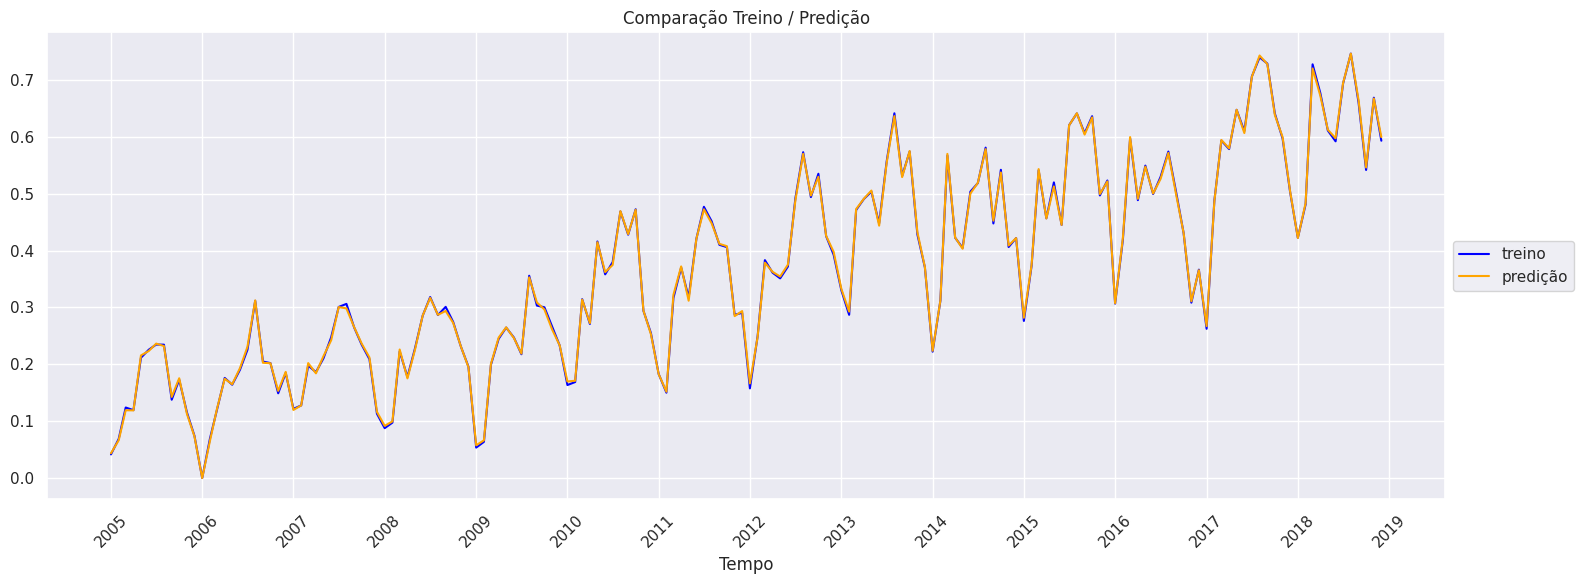

In [60]:
import matplotlib.dates as mdates

#Supondo que x_treino e x_teste sejam arrays de datas
fig, ax = plt.subplots(figsize=(16,6))

sns.lineplot(x=d_treino, y=y_treino, label='treino', ax=ax, color='blue')
sns.lineplot(x=d_treino, y=y_pred, label='predição', ax=ax, color='orange')

# Adicionando linha de separação entre treino e teste
#ax.axvline(x=d_teste[0], linestyle='--', label='Início do teste', color='k')

# Configurando formatação do eixo x para datas mensais
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45)

# Configurando a legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Definindo títulos e rótulos
ax.set(title='Comparação Treino / Predição', xlabel='Tempo', ylabel='')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()

## Predizendo e comparando o teste

In [61]:
# Definição das Variáveis para Novos Pontos de Dados
vars = {}
vars["X"] = x_teste
vars["y"] = np.zeros(len(x_teste),)
vars["f_f"] = get_fourier(len(x_teste),7).values

In [62]:
with prophet_p:
    pm.set_data(vars)
    trace_post_teste = pm.sample_posterior_predictive(trace_p_p)

In [63]:
# Cálculo do MAE
y_pred = trace_post_teste.posterior_predictive["likelihood"].values.mean(axis=1)[0]
print(f"MAE: {abs(y_pred - y_teste).sum()/len(y_teste)}")

MAE: 0.2707059453852588


In [64]:
y_pred

array([1.80843781, 2.27814435, 2.05842706, 1.42969314, 0.8911695 ,
       0.75480879, 0.84434003, 0.86649593, 0.76407328, 0.67220411,
       0.6872259 , 0.71720801, 0.67855463, 0.60682444, 0.57264102,
       0.61034723, 0.63293268, 0.63510837, 0.68475229, 0.74635998,
       0.79823422, 0.74535577, 0.69487682, 0.70846502, 0.73595445,
       0.75767118, 0.75024992, 0.76909137, 0.81983617, 0.83299892,
       0.77632382, 0.72361144, 0.74517447, 0.75881474, 0.74350739,
       0.71241424, 0.75545672, 0.83867556, 0.81167696, 0.65360414,
       0.56247991, 0.6926467 , 0.89324242, 0.92053885, 0.7179103 ,
       0.72027672, 1.29735883, 2.24924025])

<ipython-input-65-174be3e308f1>:5: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_teste, group="posterior_predictive", num_samples=200)["likelihood"],


Text(0.5, 1.0, 'Posterior predictive do teste')

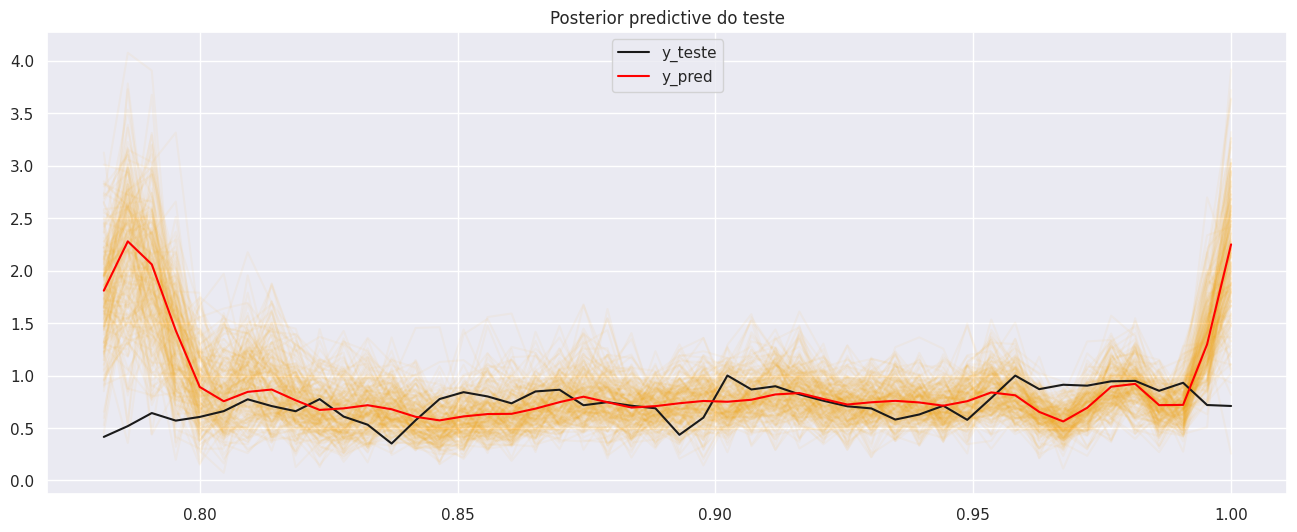

In [65]:
# Visualização das Previsões a Posteriori
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(
    x_teste,
    az.extract_dataset(trace_post_teste, group="posterior_predictive", num_samples=200)["likelihood"],
    color="orange",
    alpha=0.05
)
sns.lineplot(x=x_teste.flatten(), y=y_teste.flatten(), color="k", label='y_teste', ax=ax)
sns.lineplot(x=x_teste.flatten(), y=y_pred.flatten(), color="red", label='y_pred', ax=ax)
ax.set_title("Posterior predictive do teste")

# Predição pelo Prophet FFT para 2023

In [66]:
# Geração de novos pontos de dados (meses adicionais)
more_months = 12
passo = 1/(max_month-min_month)
new_points = np.arange(1+passo , 1 + (more_months+1) * passo, passo)
#np.linspace(1+passo, y, int((y - x) / p) + 1)
new_points

array([1.00465116, 1.00930233, 1.01395349, 1.01860465, 1.02325581,
       1.02790698, 1.03255814, 1.0372093 , 1.04186047, 1.04651163,
       1.05116279, 1.05581395])

In [67]:
# Definição das Variáveis para Novos Pontos de Dados
vars = {}
vars["X"] = new_points
vars["y"] = np.zeros(len(new_points),)
vars["f_f"] = get_fourier(len(new_points),7).values

In [68]:
vars

{'X': array([1.00465116, 1.00930233, 1.01395349, 1.01860465, 1.02325581,
        1.02790698, 1.03255814, 1.0372093 , 1.04186047, 1.04651163,
        1.05116279, 1.05581395]),
 'y': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'f_f': array([[ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
          1.00000000e+00,  0.00000000e+00,  1.00000000e+00,
          0.00000000e+00,  1.00000000e+00],
        [ 5.40640817e-01,  8.41253533e-01,  9.09631995e-01,
          4.15415013e-01,  9.89821442e-01, -1.42314838e-01,
          7.55749574e-01, -6.54860734e-01,  2.81732557e-01,
         -9.59492974e-01, -2.81732557e-01, -9.59492974e-01,
         -7.55749574e-01, -6.54860734e-01, -9.89821442e-01,
         -1.42314838e-01, -9.09631995e-01,  4.15415

In [69]:
# Amostragem Posterior Preditiva
with prophet_p:
  pm.set_data(vars)
  trace_post_p_m = pm.sample_posterior_predictive(trace_p_p)

In [70]:
# Cálculo das Médias das Previsões
likelihood_values = trace_post_p_m.posterior_predictive["likelihood"].values
mean_likelihood = np.mean(likelihood_values, axis=(0, 1))
mean_likelihood

array([2.20436696, 1.00974953, 0.83699564, 0.70659501, 0.75945427,
       0.84632125, 0.84986305, 0.86699368, 0.79601945, 0.80238676,
       0.99375519, 2.29793413])

In [71]:
# Amostragem posterior preditiva
trace_post_p_m

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

<ipython-input-72-8f897621bfd2>:5: FutureWarning: extract_dataset has been deprecated, please use extract
  az.extract_dataset(trace_post_p_m, group="posterior_predictive", num_samples=200)["likelihood"],


<Axes: title={'center': 'Posterior predictive'}>

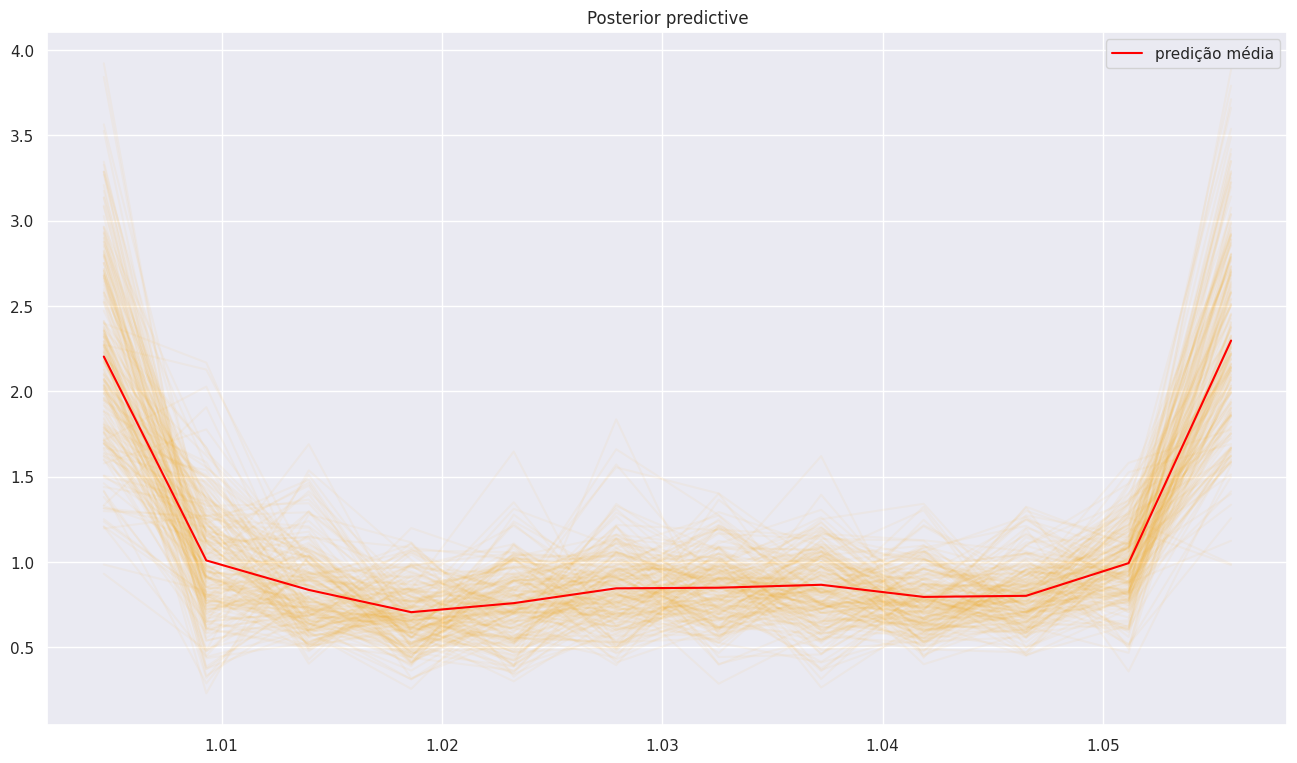

In [72]:
# Visualização das Previsões Anteriores e Novas
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(
    vars['X'],
    az.extract_dataset(trace_post_p_m, group="posterior_predictive", num_samples=200)["likelihood"],
    color="orange",
    alpha=0.05,
)
ax.set_title("Posterior predictive")
sns.lineplot(x=vars['X'].flatten(), y=mean_likelihood.flatten(), color="red", label='predição média', ax=ax)

In [73]:
maximo_mov = original.porto.max()
minimo_mov = original.porto.min()
pred_std = mean_likelihood * (maximo_mov - minimo_mov) + minimo_mov
pred_std

array([27905011.1445655 , 15268994.28621652, 13441697.0274283 ,
       12062389.71311536, 12621506.40900114, 13540338.35103305,
       13577801.58290816, 13759000.0707241 , 13008273.13332379,
       13075623.07820148, 15099814.73377294, 28894714.0650313 ])

# Comparando os dados de 2023 Previstos x Realizados

In [74]:
posterior_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PI5/staging/posterior_ts.csv')

In [75]:
linear_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PI5/staging/linear_reg.csv')
linear_df['data'] = pd.to_datetime(linear_df['data'])

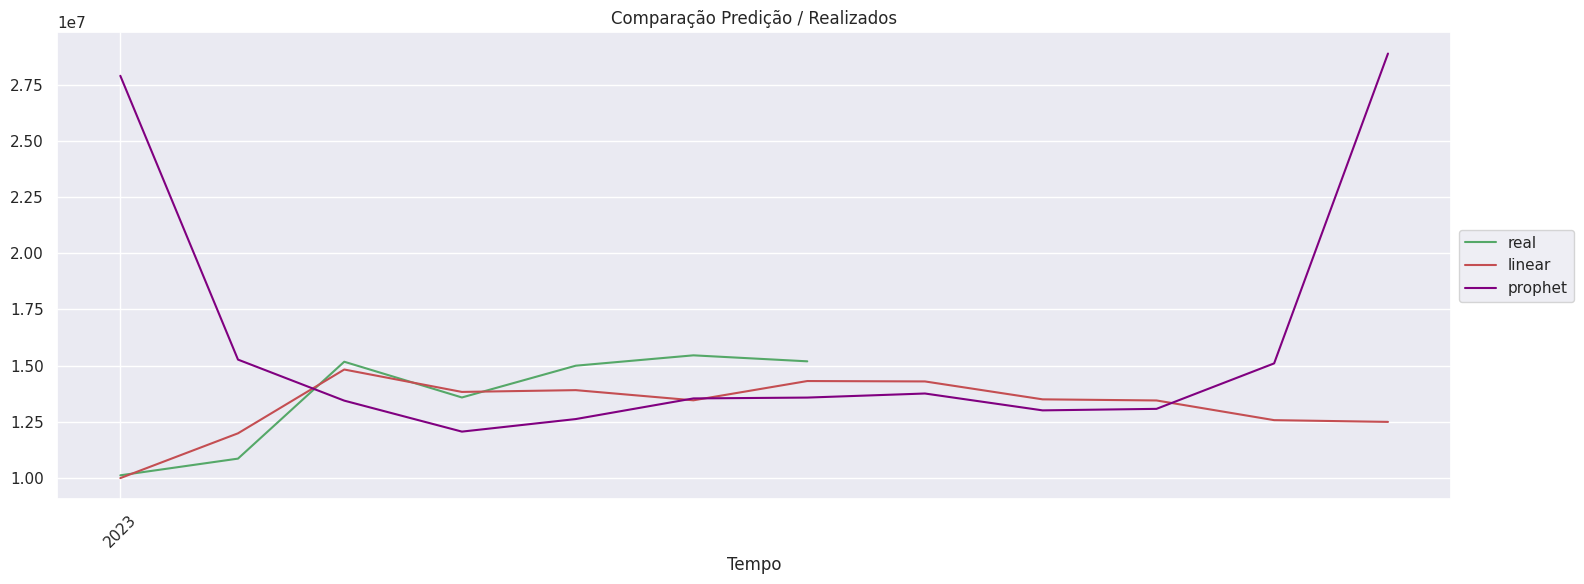

In [76]:
fig, ax = plt.subplots(figsize=(16,6))

sns.lineplot(x=linear_df.data, y=posterior_df.porto, label='real', ax=ax, color='g')
sns.lineplot(x=linear_df.data, y=linear_df.porto, label='linear', ax=ax, color='r')
sns.lineplot(x=linear_df.data, y=pred_std, label='prophet', ax=ax, color='purple')

# Configurando formatação do eixo x para datas mensais
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=[1]))

# Rotacionando os rótulos do eixo x
plt.xticks(rotation=45)

# Configurando a legenda
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Definindo títulos e rótulos
ax.set(title='Comparação Predição / Realizados', xlabel='Tempo', ylabel='')

plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()